### Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

#### Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#### Create Database Connection

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

####  Reflect an existing database into a new model

In [6]:
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

#### We can view all of the classes that automap found

In [7]:
Base.classes.keys()

['measurement', 'station']

#### Save references to each table

In [8]:
Measurement = Base.classes.measurement
Station = Base.classes.station

#### Create our session (link) from Python to the DB

In [9]:
session = Session(engine)

#### Getting column names for measurement table

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


#### Getting column names for Station table

In [11]:
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Exploratory Climate Analysis

## Precipitation Analysis

##### Query last date in dataframe

In [12]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

##### Calculate the date 1 year ago from the last data point in the database

In [13]:
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

##### Perform a query to retrieve the data and precipitation scores

In [14]:
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).limit(10).all()
all_scores

[('2017-08-23', 0.0),
 ('2017-08-23', 0.0),
 ('2017-08-23', 0.08),
 ('2017-08-23', 0.45),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.0),
 ('2017-08-22', 0.5),
 ('2017-08-21', 0.0),
 ('2017-08-21', 0.02),
 ('2017-08-21', None)]

#####  Query to retrieve the Last 12 Months of Precipitation Data Selecting Only the `date` and `prcp` Values

In [15]:
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all()
prcp_data

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

##### Save the query results as a Pandas DataFrame and set the index to the date column

In [16]:
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


##### Sort the dataframe by date

In [17]:
prcp_df.sort_values(by="Date",ascending= True)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


##### Use Pandas Plotting with Matplotlib to plot the data

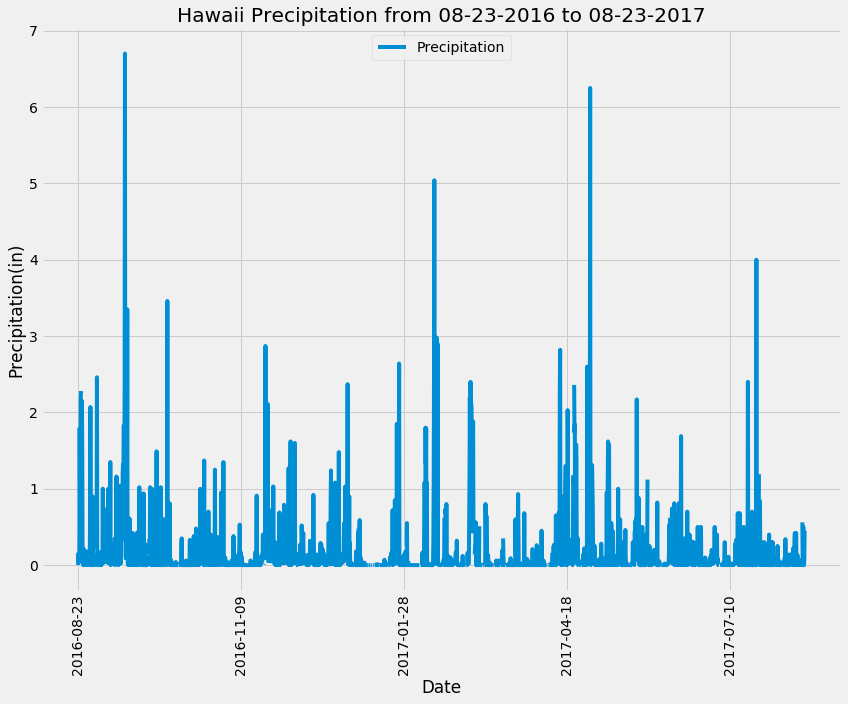

In [18]:
prcp_df.plot(title="Hawaii Precipitation from 08-23-2016 to 08-23-2017", figsize=(12, 10), rot=90 )
plt.ylabel("Precipitation(in)")
plt.legend(loc='upper center')
plt.tight_layout()

plt.savefig("images/precipitation.png")
plt.show()



##### Use Pandas to calculate the summary statistics for the precipitation data

In [19]:
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

 ##### Design a query to show how many stations are available in this dataset?

In [20]:
station_count = session.query(Station.station).distinct().count()
print(f"Number of stations: {station_count}")

Number of stations: 9


##### What are the most active stations? (i.e. what stations have the most rows)?
##### List the stations and the counts in descending order.

In [21]:
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
#set the most active station
stationID = most_active_stations[0][0]

#query for station name
stationName = (session.query(Station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")

The most active station is USC00519281: WAIHEE 837.5, HI US.


##### Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station

In [23]:
highestTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID).order_by(Measurement.tobs.desc()).first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded there is {highestTemp} degrees Farenheit.")

The highest temperature recorded there is 85.0 degrees Farenheit.


In [24]:
lowestTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID).order_by(Measurement.tobs.asc()).first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded there is {lowestTemp} degrees Farenheit.")

The lowest temperature recorded there is 54.0 degrees Farenheit.


In [25]:
avgTemp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == stationID))
avgTemp = avgTemp[0][0]
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The average temperature recorded there is 71.66378066378067 degrees Farenheit.


##### Choose the station with the highest number of temperature observations.
##### Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [26]:
temp_data = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == stationID).order_by(Measurement.date).all())

#convert query object to data frame
temp_table = pd.DataFrame(temp_data)
temp_table = temp_table.set_index('date')
temp_table.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


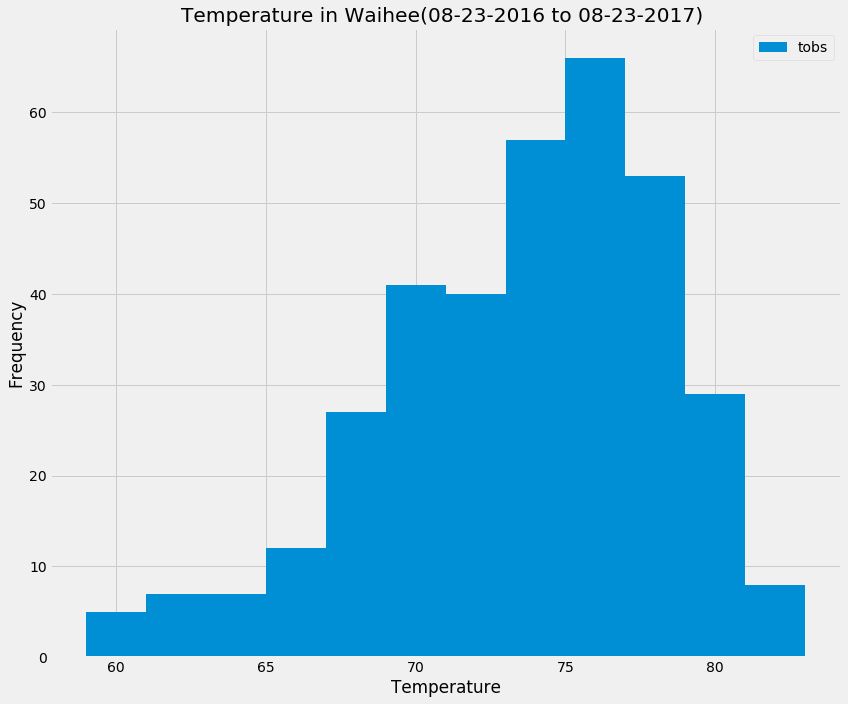

In [27]:
temp_table.plot.hist(bins=12, title="Temperature in Waihee(08-23-2016 to 08-23-2017) ", figsize=(12,10))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("images/frequency_temperature.png")
plt.show()

# Temperature Analysis

In [39]:
def calc_temps(start_date, end_date):
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function Usage Example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]
